In [7]:
import pandas as pd
import graphviz
from IPython.display import display, Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
from typing import List, Dict, Any
sys.path.append(os.path.abspath("hmm_project"))

from hmm_model.runner import run_experiment
from hmm_model.plotting import plot_kld_state_distribution, summarize_and_plot
from hmm_model.preprocessing import ObservationPreprocessor, ParticipantSimulator

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [8]:

#hidden states and observable states
hidden_states = {
    0: "Engaged",
    1: "Frustrated"
}

observable_states = {
    0: "Low click frequency",
    1: "High click frequency",
    2: "Click misfire",
    3: "Mouse-gaze aligned (≤ 35 px)",
    4: "Mouse-gaze misaligned (> 35 px)",
    5: "Matching velocity (mouse ≈ gaze)",
    6: "Mismatching velocity (mouse ≠ gaze)",
    7: "Cursor reversal (to be confirmed)"
}

#  the emission probability matrix
emission_matrix = [
    [0.3, 0.1, 0.05, 0.25, 0.1, 0.15, 0.05, 0.0],   # engaged
    [0.05, 0.3, 0.2, 0.05, 0.15, 0.1, 0.1, 0.05]    # frustrated
]

df = pd.DataFrame(emission_matrix, index=[hidden_states[i] for i in range(2)],
                  columns=[observable_states[i] for i in range(8)])

df

,Low click frequency,High click frequency,Click misfire,Mouse-gaze aligned (≤ 35 px),Mouse-gaze misaligned (> 35 px),Matching velocity (mouse ≈ gaze),Mismatching velocity (mouse ≠ gaze),Cursor reversal (to be confirmed)
Engaged,0.30,0.1,0.05,0.25,0.10,0.15,0.05,0.00
Frustrated,0.05,0.3,0.20,0.05,0.15,0.10,0.10,0.05


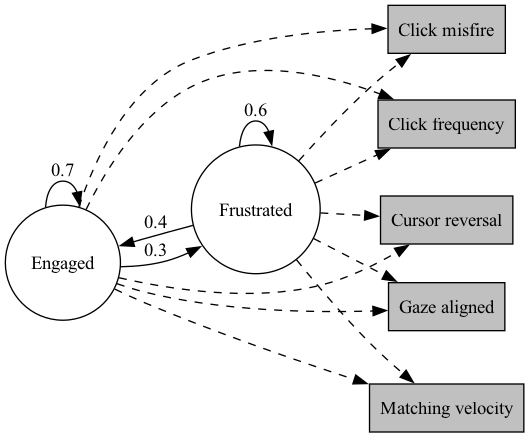

In [19]:
dot = graphviz.Digraph(format='png')
dot.attr(rankdir='LR', size='8,5')

dot.node("Engaged", shape='circle')
dot.node("Frustrated", shape='circle')

dot.edge("Engaged", "Engaged", label="0.7")
dot.edge("Engaged", "Frustrated", label="0.3")
dot.edge("Frustrated", "Engaged", label="0.4")
dot.edge("Frustrated", "Frustrated", label="0.6")

observables = [
    "Click frequency" ,  "Click misfire",
    "Gaze aligned", "Matching velocity",
    "Cursor reversal"
]

for i, obs in enumerate(observables):
    obs_node = f"O{i}"
    dot.node(obs_node, obs, shape='box', style='filled', fillcolor='grey')
    dot.edge("Engaged", obs_node, style='dashed')
    dot.edge("Frustrated", obs_node, style='dashed')

from pathlib import Path
output_path = Path("hmm_diagram_inline")
dot.render(output_path.stem, format='png', cleanup=True)
display(Image(filename=output_path.with_suffix('.png')))

In [14]:
def run_multiple_seeds(seeds, show_plot=False):
    results = []

    for seed in seeds:
        print(f"\nRunning experiment for seed {seed}...")
        result = run_experiment(seed=seed, show_plot=show_plot)
        results.append({
            "Seed": seed,
            "Accuracy": result["accuracy"],  })
    return results

def summarize_results(results):
    df = pd.DataFrame(results)
    display(df)
    return df

In [15]:
seeds_to_test = [42, 123, 777, 2025, 1550, 45, 62, 742, 46, 377, 2234, 341, 85, 4, 90]
results = run_multiple_seeds(seeds_to_test, show_plot=False)
df_summary = summarize_results(results)


Running experiment for seed 42...


TypeError: run_experiment() missing 1 required positional argument: 'n_samples'

In [20]:

plt.figure(figsize=(7, 4))
sns.barplot(x="Seed", y="Accuracy", data=df_summary)
plt.title("Accuracy per Random Seed")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


NameError: name 'df_summary' is not defined

<Figure size 700x400 with 0 Axes>

In [ ]:

seeds = np.random.randint(0, 10000, size=1000)  # 1000 random seeds
results = run_multiple_seeds(seeds, show_plot=False)


In [ ]:
df_summary = summarize_results(results)
df_summary.to_csv("Logs/seed_accuracy_1000.csv", index=False)

In [ ]:
best_runs = df_summary[df_summary["Accuracy"] > 0.9]
worst_runs = df_summary[df_summary["Accuracy"] < 0.6]

In [ ]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=df_summary, x="Seed", y="Accuracy", marker="o")
plt.title("Accuracy Fluctuation by Seed")
plt.xlabel("Seed")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df_summary["Accuracy"], bins=30, kde=True)
plt.title("Distribution of Model Accuracy Over Seeds")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
best = df_summary[df_summary["Accuracy"] == df_summary["Accuracy"].max()]
worst = df_summary[df_summary["Accuracy"] == df_summary["Accuracy"].min()]

print("Best Seed:", best)
print("Worst Seed:", worst)


In [ ]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=df_summary, x="Seed", y="Accuracy", marker="o", linewidth=2)
plt.title("Accuracy Fluctuation by Seed", fontsize=14)
plt.xlabel("Seed", fontsize=12)
plt.ylabel("Accuracy (Hidden State Prediction)", fontsize=12)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

sample_sizes = [5, 10, 20, 30, 40, 80, 160, 320, 640, 1280, 2560,]
results = []

for size in sample_sizes:
    res = run_experiment(n_samples=size, seed=1550, show_plot=False)
    results.append(res)

summary_df = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
sns.lineplot(data=summary_df, x="sample_size", y="accuracy", marker="o", label="Accuracy")
sns.lineplot(data=summary_df, x="sample_size", y="kld_transmat", marker="s", label="KLD - Transition Matrix")
sns.lineplot(data=summary_df, x="sample_size", y="kld_startprob", marker="^", label="KLD - Start Probabilities")

plt.title("Model Accuracy and KL Divergence vs Sample Size")
plt.xlabel("Sample Size")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
simulator = ParticipantSimulator(n_steps=100, random_seed=42)
X = simulator.generate_categorized_observations()

print(X.shape)  # should be (100, 5) observations
print(X[:5])    #  first 5 observations



AttributeError: 'ParticipantSimulator' object has no attribute 'preprocessor'

In [25]:
def random_probabilities(n):
    return np.random.dirichlet(np.ones(n))

probs = random_probabilities(700)
print(probs)
print("Sum:", np.sum(probs)) 

[7.03532110e-04 2.39457773e-03 8.16424921e-04 6.67963657e-04
 8.76972848e-04 5.06345599e-04 1.94377336e-03 9.86307321e-04
 3.73065119e-04 3.24486156e-03 6.83793327e-04 1.10727217e-03
 3.34532128e-03 1.38189669e-03 1.75510910e-04 3.96810856e-03
 1.39499511e-03 5.75780789e-04 2.11741540e-04 2.23069090e-03
 1.36633298e-03 1.07639757e-03 3.16715943e-03 2.19396729e-03
 2.32233523e-04 5.27406233e-04 4.03316491e-04 1.92342997e-03
 4.81539947e-05 1.19117879e-03 2.02938156e-03 2.95589909e-03
 5.91096697e-04 2.43089745e-03 1.65528251e-04 2.64540500e-03
 1.92544641e-04 7.14829394e-04 2.25328576e-03 2.29311702e-04
 3.67630274e-04 1.80861307e-03 1.79739338e-03 1.44690420e-03
 1.67160728e-03 1.10471213e-03 4.09548416e-04 5.98873895e-04
 2.82932218e-04 3.37550692e-03 1.23620976e-03 7.23202989e-04
 8.75203045e-04 4.15476224e-03 2.35026445e-04 1.24586039e-03
 9.95331199e-04 1.33466399e-03 2.58028312e-05 2.90369840e-03
 3.79780231e-03 1.17565137e-03 1.68412883e-03 3.61070797e-03
 1.73428646e-03 2.336724